# Cryptocurrency Cointegration Analysis

This notebook performs pairwise cointegration analysis on 10 cryptocurrencies using the most recent 7 days of hourly data.

## Overview
- Fetches 7 days of hourly data for 10 cryptocurrencies
- Performs pairwise cointegration tests using the Engle-Granger test
- Identifies cointegrated pairs and calculates hedge ratios
- Visualizes results

## Note on API Credentials
This notebook requires Alpaca API credentials. If you don't have them set up, the notebook will use sample data for demonstration purposes.


In [ ]:
from datetime import datetime, timedelta
from itertools import combinations
import os
import pandas as pd
import sys
from zoneinfo import ZoneInfo

from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

env_path = os.path.join(os.path.dirname(os.getcwd()), '..', '.env_example')
load_dotenv(env_path)

print(f"Loading API credentials from: {env_path}")
print(f"API Key loaded: {'Yes' if os.getenv('ALPACA_API_KEY') else 'No'}")
print(f"Secret Key loaded: {'Yes' if os.getenv('ALPACA_SECRET_KEY') else 'No'}")

# Add the src directory to the path to import our modules
current_dir = os.getcwd()
src_dir = os.path.dirname(current_dir)  # Go up one level from trading_strategy to src
sys.path.insert(0, src_dir)

print(f"Current directory: {current_dir}")
print(f"Added to Python path: {src_dir}")

# Import our custom modules with error handling
try:
    from finance.crypto import fetch_crypto_data_for_cointegration, CRYPTO_TICKERS
    from finance import TIME_FRAMES
    from trading_strategy.stat_tests import pairwise_cointegration_check, find_all_pairs
    print("✓ Successfully imported custom modules")
    API_AVAILABLE = True
except Exception as e:
    print(f"✗ Import error: {e}")
    print("This is likely due to missing API credentials (ALPACA_API_KEY, ALPACA_SECRET_KEY)")
    print("The notebook will use sample data for demonstration purposes.")
    
    # Import just the stat_tests module
    try:
        from stat_tests import pairwise_cointegration_check, find_all_pairs
        print("✓ Successfully imported stat_tests from current directory")
        
        # Create dummy constants for testing
        CRYPTO_TICKERS = ['BTC/USD', 'ETH/USD', 'BCH/USD', 'LTC/USD', 'DOGE/USD', 
                         'LINK/USD', 'UNI/USD', 'AAVE/USD', 'DOT/USD', 'AVAX/USD']
        TIME_FRAMES = {'hour': '1h', 'day': '1d'}
        print("✓ Created dummy constants for testing")
        API_AVAILABLE = False
    except ImportError as e2:
        print(f"✗ stat_tests import also failed: {e2}")
        API_AVAILABLE = False

# Set up plotting style
try:
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")
    print("✓ Plotting styles set successfully")
except Exception as e:
    print(f"⚠ Plotting style warning: {e}")
    plt.style.use('default')

print("Libraries imported successfully!")


Loading API credentials from: /Users/daniel/Quant_Trading_Sam/tp-link/src/../.env_example
API Key loaded: Yes
Secret Key loaded: Yes
Current directory: /Users/daniel/Quant_Trading_Sam/tp-link/src/trading_strategy
Added to Python path: /Users/daniel/Quant_Trading_Sam/tp-link/src
✓ Successfully imported custom modules
✓ Plotting styles set successfully
Libraries imported successfully!


## Step 1: Select 10 Cryptocurrencies

We'll select 10 major cryptocurrencies from the available tickers for our analysis.


In [ ]:
# Select 10 major cryptocurrencies for analysis
# what a pointless block of code
selected_cryptos = [
    'BTC/USD',   # Bitcoin
    'ETH/USD',   # Ethereum
    'BCH/USD',   # Bitcoin Cash
    'LTC/USD',   # Litecoin
    'DOGE/USD',  # Dogecoin
    'LINK/USD',  # Chainlink
    'UNI/USD',   # Uniswap
    'AAVE/USD',  # Aave
    'DOT/USD',   # Polkadot
    'AVAX/USD'   # Avalanche
]

print(f"Selected {len(selected_cryptos)} cryptocurrencies for analysis:")
for i, crypto in enumerate(selected_cryptos, 1):
    print(f"{i:2d}. {crypto}")


Selected 10 cryptocurrencies for analysis:
 1. BTC/USD
 2. ETH/USD
 3. BCH/USD
 4. LTC/USD
 5. DOGE/USD
 6. LINK/USD
 7. UNI/USD
 8. AAVE/USD
 9. DOT/USD
10. AVAX/USD


## Step 2: Fetch 7 Days of Hourly Data

We'll fetch the most recent 7 days of hourly data for all selected cryptocurrencies.


Issue loading real data

In [ ]:

days = 1

print(f"Fetching {days} days of hourly data for selected cryptocurrencies...")
print("This may take a moment due to API rate limits...")

if API_AVAILABLE:
    try:
        # Fetch data using our custom function with time alignment
        price_arrays, sorted_symbols, timestamps = fetch_crypto_data_for_cointegration(
            symbols=selected_cryptos,
            days_back=days,
            frequency=TIME_FRAMES["min"]
        )
        
        print(f"\nSuccessfully fetched time-aligned data for {len(sorted_symbols)} cryptocurrencies:")
        print(f"Common timestamps: {len(timestamps)} data points")
        print(f"Time range: {timestamps[0]} to {timestamps[-1]}")
        
        for i, (symbol, prices) in enumerate(zip(sorted_symbols, price_arrays)):
            valid_prices = prices[~np.isnan(prices)]
            print(f"{i+1:2d}. {symbol}: {len(valid_prices)} valid data points")
            print(f"    Price range: ${valid_prices.min():.2f} - ${valid_prices.max():.2f}")
        
        # Normalize symbol index lookup for downstream plots
        sorted_symbols = list(sorted_symbols)
        sym_to_ix = {s: i for i, s in enumerate(sorted_symbols)}
            
    except Exception as e:
        print(f"Error fetching data: {e}")
        print("Falling back to sample data...")
        API_AVAILABLE = False

if not API_AVAILABLE:
    print("\nUsing sample data for demonstration purposes...")
    
    # Create sample data for demonstration
    np.random.seed(42)
    n_points = 168  # 7 days * 24 hours
    
    # Create common timestamps
    from datetime import datetime, timedelta
    from zoneinfo import ZoneInfo
    end_time = datetime.now(ZoneInfo("America/New_York"))
    start_time = end_time - timedelta(days=7)
    timestamps = pd.date_range(start=start_time, end=end_time, freq='H')[:n_points]
    
    price_arrays = []
    sorted_symbols = selected_cryptos.copy()
    
    # Create realistic-looking price data
    base_prices = [50000, 3000, 300, 100, 0.08, 15, 6, 100, 7, 25]  # Approximate current prices
    
    print(f"Sample data timestamps: {len(timestamps)} data points")
    print(f"Time range: {timestamps[0]} to {timestamps[-1]}")
    
    for i, (symbol, base_price) in enumerate(zip(selected_cryptos, base_prices)):
        # Create a random walk with some trend
        returns = np.random.normal(0.001, 0.02, n_points)  # 0.1% mean return, 2% volatility
        prices = base_price * np.exp(np.cumsum(returns))
        price_arrays.append(prices)
        print(f"{i+1:2d}. {symbol}: {len(prices)} data points (sample data)")
        print(f"    Price range: ${prices.min():.2f} - ${prices.max():.2f}")

Fetching 1 days of hourly data for selected cryptocurrencies...
This may take a moment due to API rate limits...

Successfully fetched time-aligned data for 10 cryptocurrencies:
Common timestamps: 1439 data points
Time range: 2025-10-12 02:48:00+00:00 to 2025-10-13 02:46:00+00:00
 1. AAVE/USD: 1424 valid data points
    Price range: $225.59 - $256.38
 2. DOT/USD: 1409 valid data points
    Price range: $2.91 - $3.30
 3. LINK/USD: 1431 valid data points
    Price range: $16.71 - $19.41
 4. AVAX/USD: 1418 valid data points
    Price range: $20.68 - $23.32
 5. BCH/USD: 1275 valid data points
    Price range: $497.99 - $547.56
 6. BTC/USD: 1437 valid data points
    Price range: $109790.70 - $115854.45
 7. DOGE/USD: 1415 valid data points
    Price range: $0.18 - $0.21
 8. ETH/USD: 1287 valid data points
    Price range: $3715.41 - $4205.32
 9. LTC/USD: 1400 valid data points
    Price range: $92.19 - $102.03
10. UNI/USD: 1418 valid data points
    Price range: $5.83 - $6.70


In [ ]:
## Step 3: Data Quality Check

lengths = [len(prices) for prices in price_arrays]
if len(set(lengths)) == 1:
    print(f"\n✓ All time series have the same length: {lengths[0]} data points")
else:
    print(f"\n⚠ Warning: Time series have different lengths: {lengths}")
    print("This may cause issues with cointegration analysis.")



✓ All time series have the same length: 1439 data points


## Step 4: Visualize Price Data

Let's create visualizations to understand the price movements of our selected cryptocurrencies.


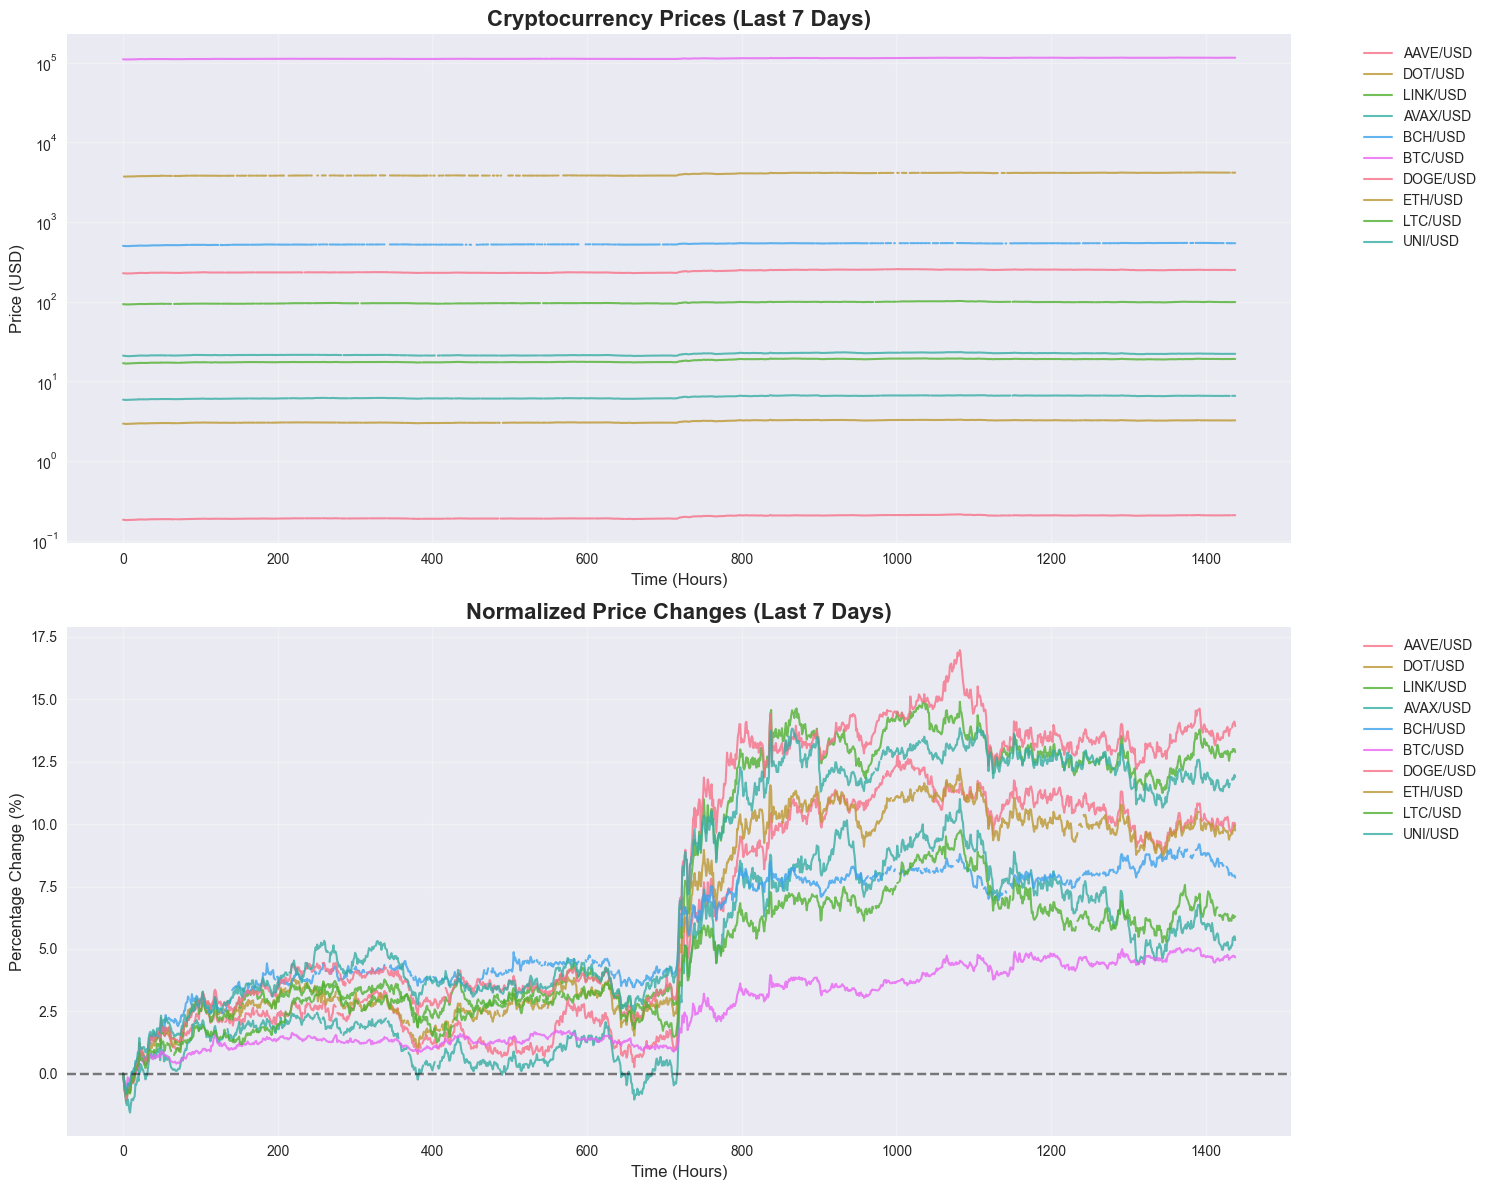

In [ ]:
# Create price visualization
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Raw prices (log scale for better comparison)
ax1 = axes[0]
for i, (symbol, prices) in enumerate(zip(sorted_symbols, price_arrays)):
    ax1.plot(prices, label=symbol, linewidth=1.5, alpha=0.8)

ax1.set_title('Cryptocurrency Prices (Last 7 Days)', fontsize=16, fontweight='bold')
ax1.set_ylabel('Price (USD)', fontsize=12)
ax1.set_xlabel('Time (Hours)', fontsize=12)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')  # Log scale for better comparison

# Plot 2: Normalized prices (percentage change from start)
ax2 = axes[1]
for i, (symbol, prices) in enumerate(zip(sorted_symbols, price_arrays)):
    normalized_prices = (prices / prices[0] - 1) * 100
    ax2.plot(normalized_prices, label=symbol, linewidth=1.5, alpha=0.8)

ax2.set_title('Normalized Price Changes (Last 7 Days)', fontsize=16, fontweight='bold')
ax2.set_ylabel('Percentage Change (%)', fontsize=12)
ax2.set_xlabel('Time (Hours)', fontsize=12)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


## Step 5: Perform Pairwise Cointegration Analysis

Now we'll perform cointegration tests on all possible pairs of cryptocurrencies.


In [ ]:
print("Performing pairwise cointegration analysis...")
print("=" * 50)

# Data validation: All arrays should now be time-aligned
print("Validating time-aligned data consistency...")
lengths = [len(prices) for prices in price_arrays]
print(f"Data lengths: {lengths}")

if len(set(lengths)) > 1:
    print("Warning: Arrays still have different lengths despite time alignment!")
else:
    print(f"✓ All arrays have consistent length: {lengths[0]}")

# Set significance level for cointegration test
p_threshold = 0.05

# Store results
cointegration_results = []
significant_pairs = []

# Generate all possible pairs
pairs = list(combinations(range(len(sorted_symbols)), 2))
print(f"Testing {len(pairs)} pairs for cointegration with time-aligned data...")

for i, (idx1, idx2) in enumerate(pairs):
    symbol1, symbol2 = sorted_symbols[idx1], sorted_symbols[idx2]
    prices1, prices2 = price_arrays[idx1], price_arrays[idx2]
    
    print(f"\n{i+1:2d}. Testing {symbol1} vs {symbol2}...")
    
    try:
        # Perform cointegration test (function masks timestamps without both points)
        hedge_ratio = pairwise_cointegration_check(prices1, prices2, p_thresh=p_threshold)
        
        # Get detailed test results on the same masked data
        from statsmodels.tsa.stattools import coint
        import numpy as np
        mask = ~(np.isnan(prices1) | np.isnan(prices2) | np.isinf(prices1) | np.isinf(prices2))
        t_stat, p_value, crit_values = coint(prices1[mask], prices2[mask])
        
        result = {
            'Pair': f"{symbol1} - {symbol2}",
            'Symbol1': symbol1,
            'Symbol2': symbol2,
            'T-Statistic': t_stat,
            'P-Value': p_value,
            'Hedge_Ratio': hedge_ratio,
            'Cointegrated': p_value < p_threshold,
            'Critical_1%': crit_values[0],
            'Critical_5%': crit_values[1],
            'Critical_10%': crit_values[2]
        }
        
        cointegration_results.append(result)
        
        if result['Cointegrated']:
            significant_pairs.append(result)
            print(f"    ✓ COINTEGRATED! (p-value: {p_value:.4f}, hedge ratio: {hedge_ratio:.4f})")
        else:
            print(f"    ✗ Not cointegrated (p-value: {p_value:.4f})")
            
    except Exception as e:
        print(f"    Error: {e}")
        continue

print(f"\n" + "=" * 50)
print(f"Analysis complete!")
print(f"Total pairs tested: {len(cointegration_results)}")
print(f"Cointegrated pairs found: {len(significant_pairs)}")


Performing pairwise cointegration analysis...
Validating time-aligned data consistency...
Data lengths: [1439, 1439, 1439, 1439, 1439, 1439, 1439, 1439, 1439, 1439]
✓ All arrays have consistent length: 1439
Testing 45 pairs for cointegration with time-aligned data...

 1. Testing AAVE/USD vs DOT/USD...
    ✗ Not cointegrated (p-value: 0.1547)

 2. Testing AAVE/USD vs LINK/USD...
    ✗ Not cointegrated (p-value: 0.2679)

 3. Testing AAVE/USD vs AVAX/USD...
    ✗ Not cointegrated (p-value: 0.5381)

 4. Testing AAVE/USD vs BCH/USD...
    ✗ Not cointegrated (p-value: 0.1096)

 5. Testing AAVE/USD vs BTC/USD...
    ✗ Not cointegrated (p-value: 0.5897)

 6. Testing AAVE/USD vs DOGE/USD...
    ✗ Not cointegrated (p-value: 0.1887)

 7. Testing AAVE/USD vs ETH/USD...
    ✗ Not cointegrated (p-value: 0.7322)

 8. Testing AAVE/USD vs LTC/USD...
    ✗ Not cointegrated (p-value: 0.1820)

 9. Testing AAVE/USD vs UNI/USD...
    ✗ Not cointegrated (p-value: 0.1667)

10. Testing DOT/USD vs LINK/USD...


## Step 6: Results Summary

Let's create a comprehensive summary of our cointegration analysis results.


In [29]:
# Create results DataFrame
results_df = pd.DataFrame(cointegration_results)

print("COINTEGRATION ANALYSIS RESULTS")
print("=" * 60)

# Summary statistics
print(f"\nSUMMARY:")
print(f"Total pairs analyzed: {len(results_df)}")
print(f"Cointegrated pairs: {len(significant_pairs)}")
print(f"Cointegration rate: {len(significant_pairs)/len(results_df)*100:.1f}%")

# Show all results
print(f"\nALL PAIRS (sorted by p-value):")
display_df = results_df.sort_values('P-Value')[['Pair', 'P-Value', 'T-Statistic', 'Hedge_Ratio', 'Cointegrated']].copy()
display_df['P-Value'] = display_df['P-Value'].round(4)
display_df['T-Statistic'] = display_df['T-Statistic'].round(4)
display_df['Hedge_Ratio'] = display_df['Hedge_Ratio'].round(4)
print(display_df.to_string(index=False))

# Show only cointegrated pairs
if significant_pairs:
    print(f"\nCOINTEGRATED PAIRS:")
    coint_df = pd.DataFrame(significant_pairs)
    coint_display = coint_df[['Pair', 'P-Value', 'T-Statistic', 'Hedge_Ratio']].copy()
    coint_display['P-Value'] = coint_display['P-Value'].round(4)
    coint_display['T-Statistic'] = coint_display['T-Statistic'].round(4)
    coint_display['Hedge_Ratio'] = coint_display['Hedge_Ratio'].round(4)
    print(coint_display.to_string(index=False))
else:
    print(f"\nNo cointegrated pairs found at {p_threshold*100}% significance level.")


COINTEGRATION ANALYSIS RESULTS

SUMMARY:
Total pairs analyzed: 45
Cointegrated pairs: 9
Cointegration rate: 20.0%

ALL PAIRS (sorted by p-value):
               Pair  P-Value  T-Statistic  Hedge_Ratio  Cointegrated
LINK/USD - DOGE/USD   0.0015      -4.4506       0.0112          True
 DOT/USD - LINK/USD   0.0061      -4.0483       7.4387          True
  BCH/USD - ETH/USD   0.0064      -4.0357      12.8016          True
 BCH/USD - DOGE/USD   0.0065      -4.0321       0.0008          True
 DOGE/USD - UNI/USD   0.0194      -3.6813      26.9632          True
  BCH/USD - UNI/USD   0.0211      -3.6524       0.0215          True
 LINK/USD - UNI/USD   0.0263      -3.5748       0.3042          True
  LTC/USD - UNI/USD   0.0414      -3.4087       0.1110          True
 LINK/USD - BCH/USD   0.0432      -3.3926      13.2346          True
 DOT/USD - DOGE/USD   0.0561      -3.2902       0.0000         False
  DOT/USD - UNI/USD   0.0733      -3.1801       0.0000         False
 DOGE/USD - LTC/USD   0.07

## Step 7: Visualize Cointegration Results

Let's create visualizations to better understand the cointegration relationships.


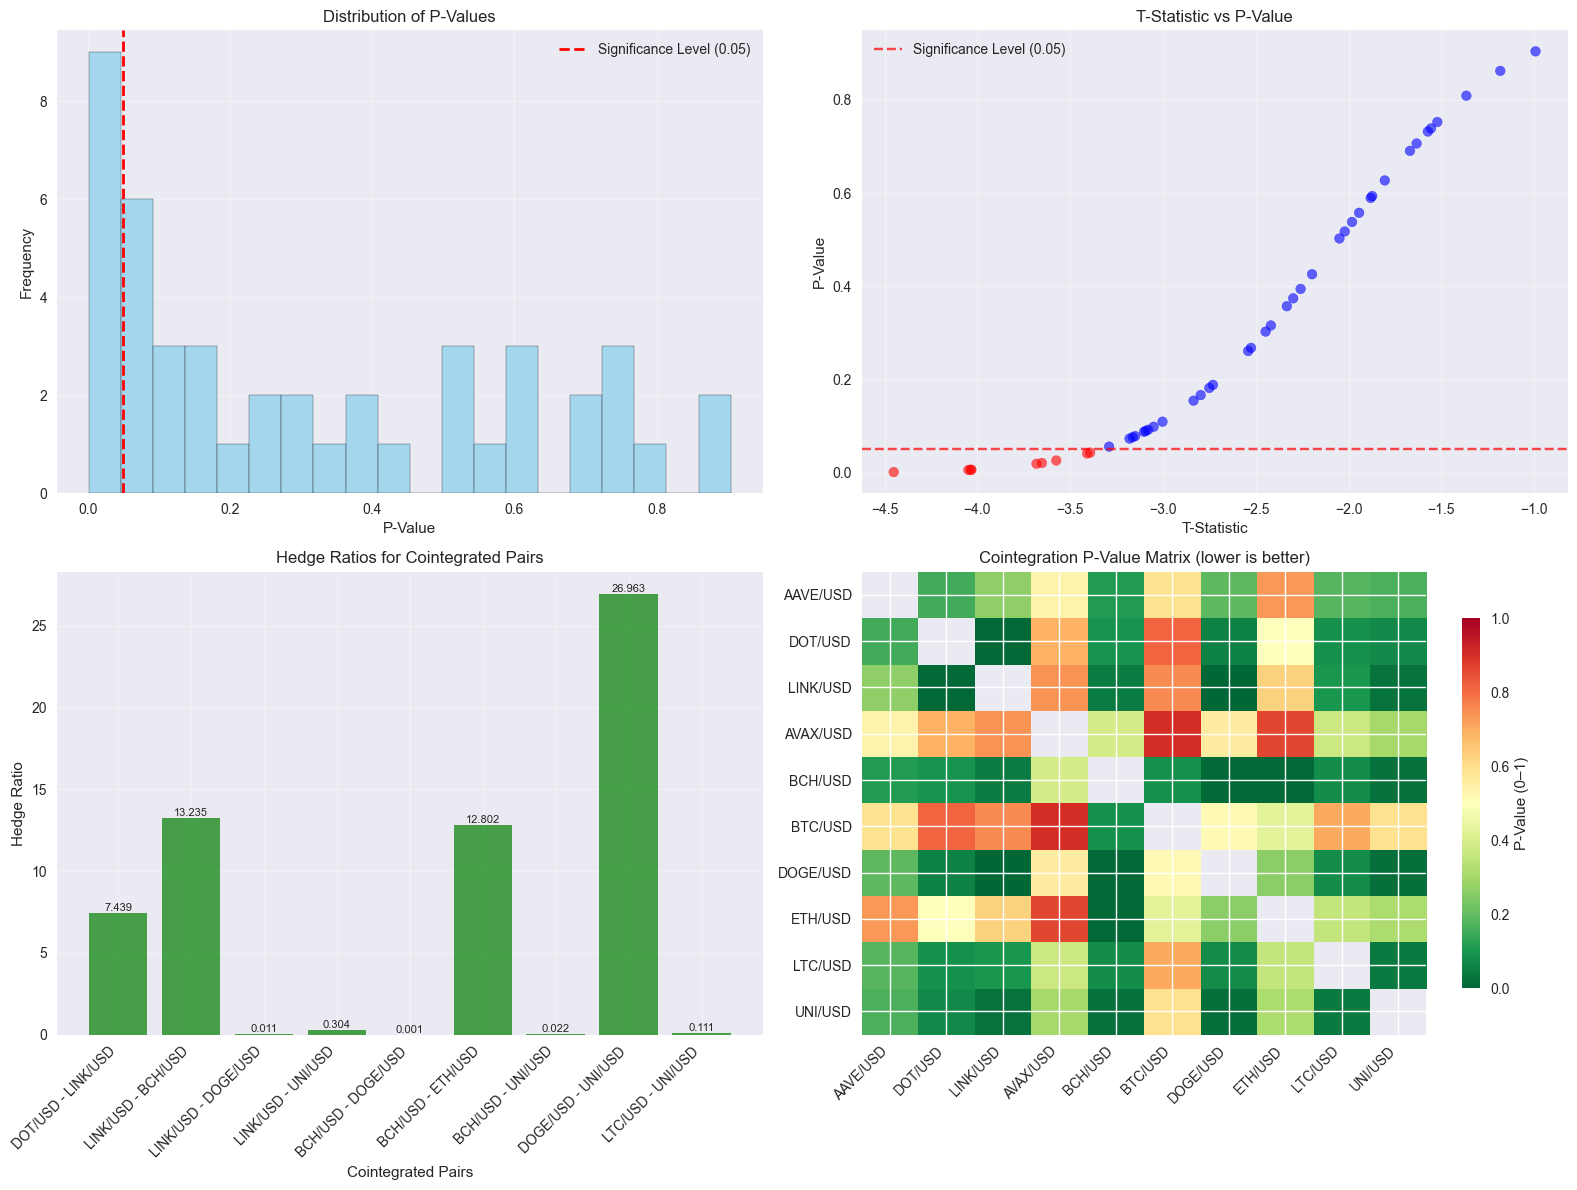

In [ ]:
# Create visualizations (robust to missing/empty data)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1) P-value distribution
ax1 = axes[0, 0]
if not results_df.empty and 'P-Value' in results_df:
    pv = results_df['P-Value'].dropna().values
    if pv.size:
        ax1.hist(pv, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        ax1.axvline(x=p_threshold, color='red', linestyle='--', linewidth=2, label=f'Significance Level ({p_threshold})')
        ax1.legend()
ax1.set_xlabel('P-Value')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of P-Values')
ax1.grid(True, alpha=0.3)

# 2) T-statistic vs P-value
ax2 = axes[0, 1]
if not results_df.empty and {'T-Statistic','P-Value','Cointegrated'}.issubset(results_df.columns):
    mask = results_df['T-Statistic'].notna() & results_df['P-Value'].notna() & results_df['Cointegrated'].notna()
    ts = results_df.loc[mask, 'T-Statistic'].values
    pv = results_df.loc[mask, 'P-Value'].values
    cols = np.where(results_df.loc[mask, 'Cointegrated'].values, 'red', 'blue')
    if ts.size and pv.size:
        ax2.scatter(ts, pv, c=cols, alpha=0.6)
        ax2.axhline(y=p_threshold, color='red', linestyle='--', alpha=0.7, label=f'Significance Level ({p_threshold})')
        ax2.legend()
ax2.set_xlabel('T-Statistic')
ax2.set_ylabel('P-Value')
ax2.set_title('T-Statistic vs P-Value')
ax2.grid(True, alpha=0.3)

# 3) Hedge ratios for cointegrated pairs
ax3 = axes[1, 0]
if significant_pairs:
    coint_df = pd.DataFrame(significant_pairs)
    if not coint_df.empty and 'Hedge_Ratio' in coint_df:
        bars = ax3.bar(range(len(coint_df)), coint_df['Hedge_Ratio'].values, alpha=0.7, color='green')
        ax3.set_xticks(range(len(coint_df)))
        ax3.set_xticklabels(list(coint_df['Pair']), rotation=45, ha='right')
        for bar in bars:
            h = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., h, f'{h:.3f}', ha='center', va='bottom', fontsize=8)
else:
    ax3.text(0.5, 0.5, 'No cointegrated pairs found', ha='center', va='center', transform=ax3.transAxes, fontsize=14)
ax3.set_xlabel('Cointegrated Pairs')
ax3.set_ylabel('Hedge Ratio')
ax3.set_title('Hedge Ratios for Cointegrated Pairs')
ax3.grid(True, alpha=0.3)

# 4) Cointegration heatmap (P-Values)
ax4 = axes[1, 1]
# Normalize symbol container and build a fast lookup
sorted_symbols = list(sorted_symbols)
sym_to_ix = {s: i for i, s in enumerate(sorted_symbols)}
n_symbols = len(sorted_symbols)
# Matrix of p-values
pval_matrix = np.full((n_symbols, n_symbols), np.nan)
for result in cointegration_results:
    i = sym_to_ix.get(result.get('Symbol1'))
    j = sym_to_ix.get(result.get('Symbol2'))
    if i is None or j is None:
        continue
    pval = result.get('P-Value')
    if pval is None or (isinstance(pval, float) and np.isnan(pval)):
        continue
    pval_matrix[i, j] = pval
    pval_matrix[j, i] = pval
np.fill_diagonal(pval_matrix, np.nan)
# Lower p-values are "better" (more green). Use reversed colormap so low=green, high=red.
im = ax4.imshow(pval_matrix, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=1)
ax4.set_xticks(range(n_symbols)); ax4.set_yticks(range(n_symbols))
ax4.set_xticklabels(sorted_symbols, rotation=45, ha='right'); ax4.set_yticklabels(sorted_symbols)
ax4.set_title('Cointegration P-Value Matrix (lower is better)')
plt.colorbar(im, ax=ax4, shrink=0.8).set_label('P-Value (0–1)')

plt.tight_layout()
plt.show()

## Step 8: Trading Strategy Implications

Let's discuss the implications of our findings for potential trading strategies.


In [ ]:
print("TRADING STRATEGY IMPLICATIONS")
print("=" * 40)

if significant_pairs:
    print(f"\nFound {len(significant_pairs)} cointegrated pairs that could be used for pairs trading:")
    
    for i, pair in enumerate(significant_pairs, 1):
        symbol1, symbol2 = pair['Symbol1'], pair['Symbol2']
        hedge_ratio = pair['Hedge_Ratio']
        
        print(f"\n{i}. {symbol1} - {symbol2}")
        print(f"   Hedge Ratio: {hedge_ratio:.4f}")
        print(f"   Strategy: When {symbol1} is relatively expensive, sell {symbol1} and buy {hedge_ratio:.4f} units of {symbol2}")
        print(f"   Risk: Monitor the spread for mean reversion opportunities")
        
    print(f"\n\nIMPORTANT CONSIDERATIONS:")
    print(f"• Cointegration relationships can break down over time")
    print(f"• Transaction costs and slippage must be considered")
    print(f"• Risk management is crucial (stop-losses, position sizing)")
    print(f"• Backtesting on longer time periods is recommended")
    print(f"• Market conditions can affect cointegration stability")
    
else:
    print(f"\nNo cointegrated pairs found in this analysis.")
    print(f"\nRECOMMENDATIONS:")
    print(f"• Try analyzing longer time periods (30+ days)")
    print(f"• Consider using daily data instead of hourly")
    print(f"• Test different cryptocurrency pairs")
    print(f"• Look for cointegration in different market conditions")
    print(f"• Consider other statistical relationships (correlation, causality)")

print(f"\n\nANALYSIS COMPLETE!")
print(f"Data period: Last 7 days (hourly frequency)")
print(f"Cryptocurrencies analyzed: {len(selected_cryptos)}")
print(f"Pairs tested: {len(cointegration_results)}")
print(f"Cointegrated pairs: {len(significant_pairs)}")


In [ ]:
print("Fetching 7 days of hourly data for selected cryptocurrencies...")
print("This may take a moment due to API rate limits...")

if API_AVAILABLE:
    try:
        # Fetch data using our custom function (returns time-aligned arrays and timestamps)
        price_arrays, sorted_symbols, timestamps = fetch_crypto_data_for_cointegration(
            symbols=selected_cryptos,
            days_back=7,
            frequency=TIME_FRAMES["min"]
        )
        
        print(f"\nSuccessfully fetched time-aligned data for {len(sorted_symbols)} cryptocurrencies:")
        print(f"Common timestamps: {len(timestamps)} data points")
        print(f"Time range: {timestamps[0]} to {timestamps[-1]}")
        for i, (symbol, prices) in enumerate(zip(sorted_symbols, price_arrays)):
            valid_prices = prices[~np.isnan(prices)]
            print(f"{i+1:2d}. {symbol}: {len(valid_prices)} valid data points")
            print(f"    Price range: ${valid_prices.min():.2f} - ${valid_prices.max():.2f}")
            
    except Exception as e:
        print(f"Error fetching data: {e}")
        print("Falling back to sample data...")
        API_AVAILABLE = False

if not API_AVAILABLE:
    print("\nUsing sample data for demonstration purposes...")
    
    # Create sample data for demonstration
    np.random.seed(42)
    n_points = 168  # 7 days * 24 hours
    
    price_arrays = []
    sorted_symbols = selected_cryptos.copy()
    
    # Create realistic-looking price data
    base_prices = [50000, 3000, 300, 100, 0.08, 15, 6, 100, 7, 25]  # Approximate current prices
    
    for i, (symbol, base_price) in enumerate(zip(selected_cryptos, base_prices)):
        # Create a random walk with some trend
        returns = np.random.normal(0.001, 0.02, n_points)  # 0.1% mean return, 2% volatility
        prices = base_price * np.exp(np.cumsum(returns))
        price_arrays.append(prices)
        print(f"{i+1:2d}. {symbol}: {len(prices)} data points (sample data)")
        print(f"    Price range: ${prices.min():.2f} - ${prices.max():.2f}")


Fetching 7 days of hourly data for selected cryptocurrencies...
This may take a moment due to API rate limits...
Error fetching data: cannot reshape array of size 11578 into shape (10,168,7)
Falling back to sample data...

Using sample data for demonstration purposes...
 1. BTC/USD: 168 data points (sample data)
    Price range: $41462.55 - $55237.12
 2. ETH/USD: 168 data points (sample data)
    Price range: $2851.89 - $4611.83
 3. BCH/USD: 168 data points (sample data)
    Price range: $268.94 - $398.34
 4. LTC/USD: 168 data points (sample data)
    Price range: $77.15 - $106.05
 5. DOGE/USD: 168 data points (sample data)
    Price range: $0.07 - $0.11
 6. LINK/USD: 168 data points (sample data)
    Price range: $14.90 - $31.03
 7. UNI/USD: 168 data points (sample data)
    Price range: $6.07 - $12.55
 8. AAVE/USD: 168 data points (sample data)
    Price range: $87.30 - $121.40
 9. DOT/USD: 168 data points (sample data)
    Price range: $5.56 - $13.14
10. AVAX/USD: 168 data points (s